In [1]:
#Clustering and RANSAC for WDD2017 paper
#Fernando Wario
#June 2017

%matplotlib notebook

import csv
import cv2
import datetime
import glob
import json
import math
import numpy as np
import os
import pandas
import sys
import scipy.cluster
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn.linear_model import TheilSenRegressor
from skimage.transform import radon, rescale
from scipy.stats import multivariate_normal
from scipy import stats

sys.path.append('../functions/')
sys.path.append('../utils/')

from VidPlayer import VidPlayer

#Radian
radi = 180/np.pi

In [2]:
#Decoder data is loaded
#DECODER DATA
#Path to the Decoder data
inputFile = '../Data/GTRuns_decoder.csv'
A = {}
DecFile = open(inputFile, 'rt', encoding='utf-8-sig')
for row in csv.reader(DecFile, delimiter = ','):
    #Only WRuns from cam1
    if (row[0][14] == '1'):        
        key = row[0]
        #duration of the WRun in ms
        length_ms = float(row[1])*10
        #Time is splitted    
        split_time = row[6].split(":")
        #Timestamp to seconds, disregard miliseconds
        time_sec = int(split_time[0])*3600 + int(split_time[1])*60 + int(split_time[2])
        A[key] = [length_ms, float(row[2]), float(row[3]), float(row[4]), time_sec, split_time[0], split_time[1]]
print('done with A')
#print(A)

done with A


(187, 3)


<IPython.core.display.Javascript object>


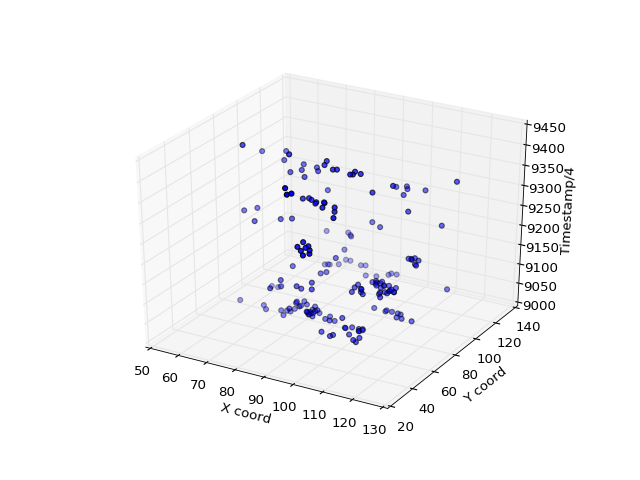

In [3]:
#Load X0, Y0 and Timestamp to B
B = np.array([[A[key][2], A[key][3], A[key][4]/4] for key in A])
print(B.shape)

#3D scatterplot
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(B[:,0], B[:,1], B[:,2], c='b', marker = 'o')

ax.set_xlabel('X coord')
ax.set_ylabel('Y coord')
ax.set_zlabel('Timestamp/4')

plt.show()

In [4]:
#Generate the linkage matrix
Z = scipy.cluster.hierarchy.linkage(B, 'ward')
print(Z.shape)
#print(Z)
#print(B)

(186, 4)


<IPython.core.display.Javascript object>


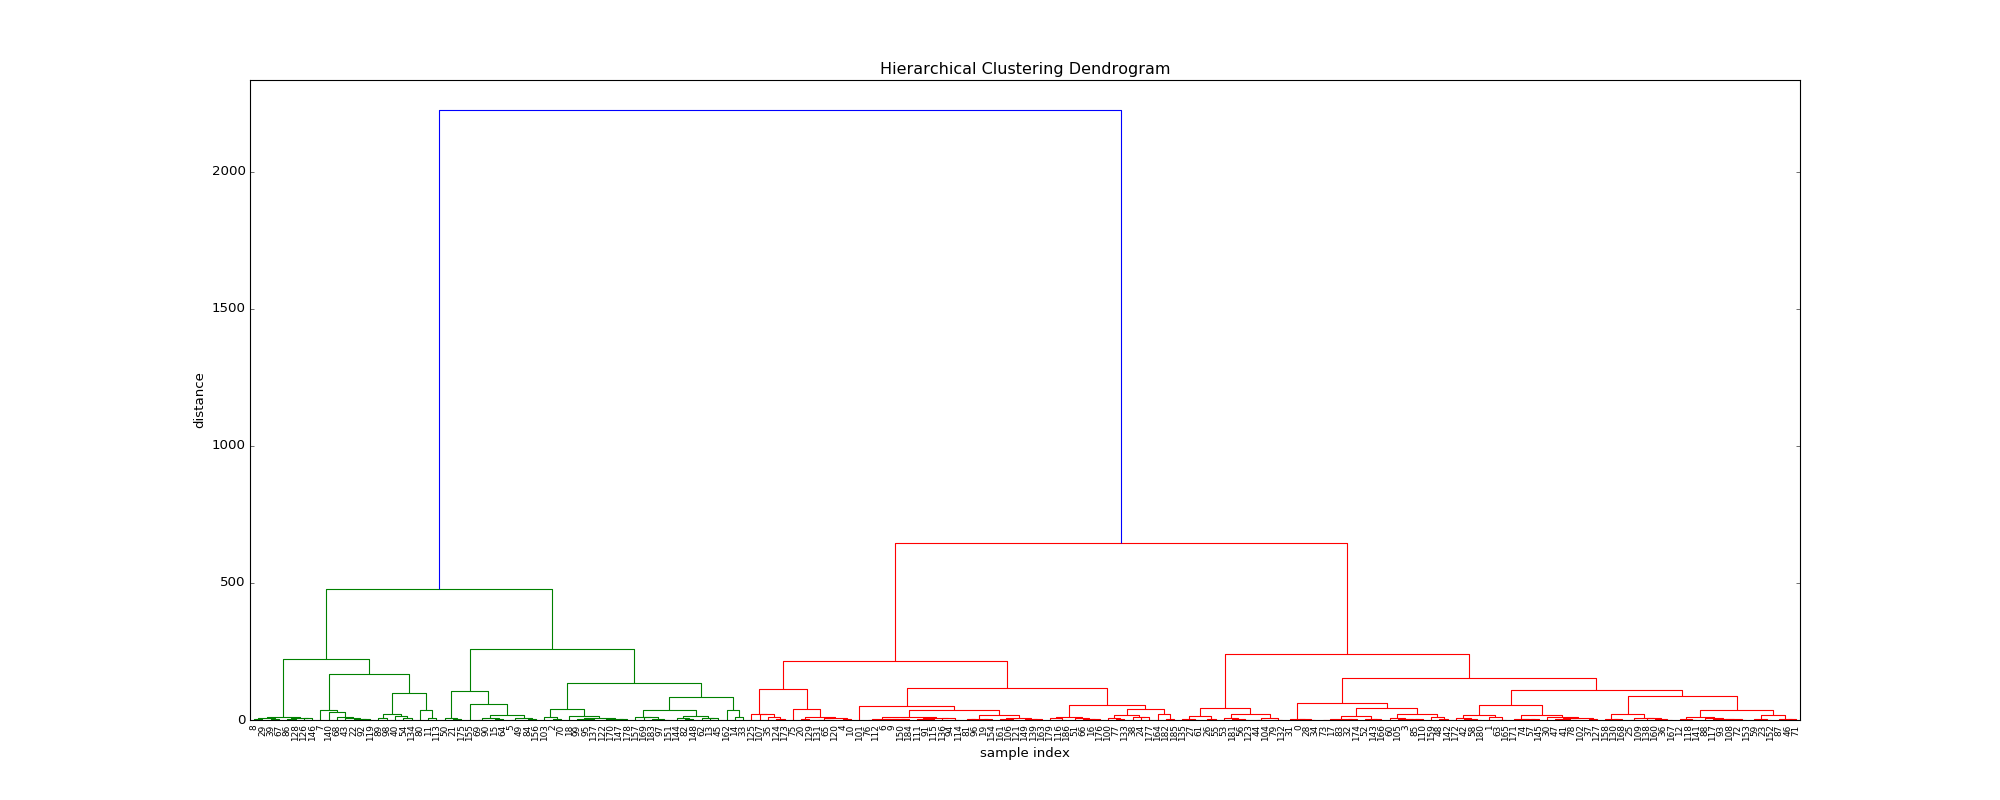

In [5]:
#Calculate full dendrogram
fig2 = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
scipy.cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

<IPython.core.display.Javascript object>


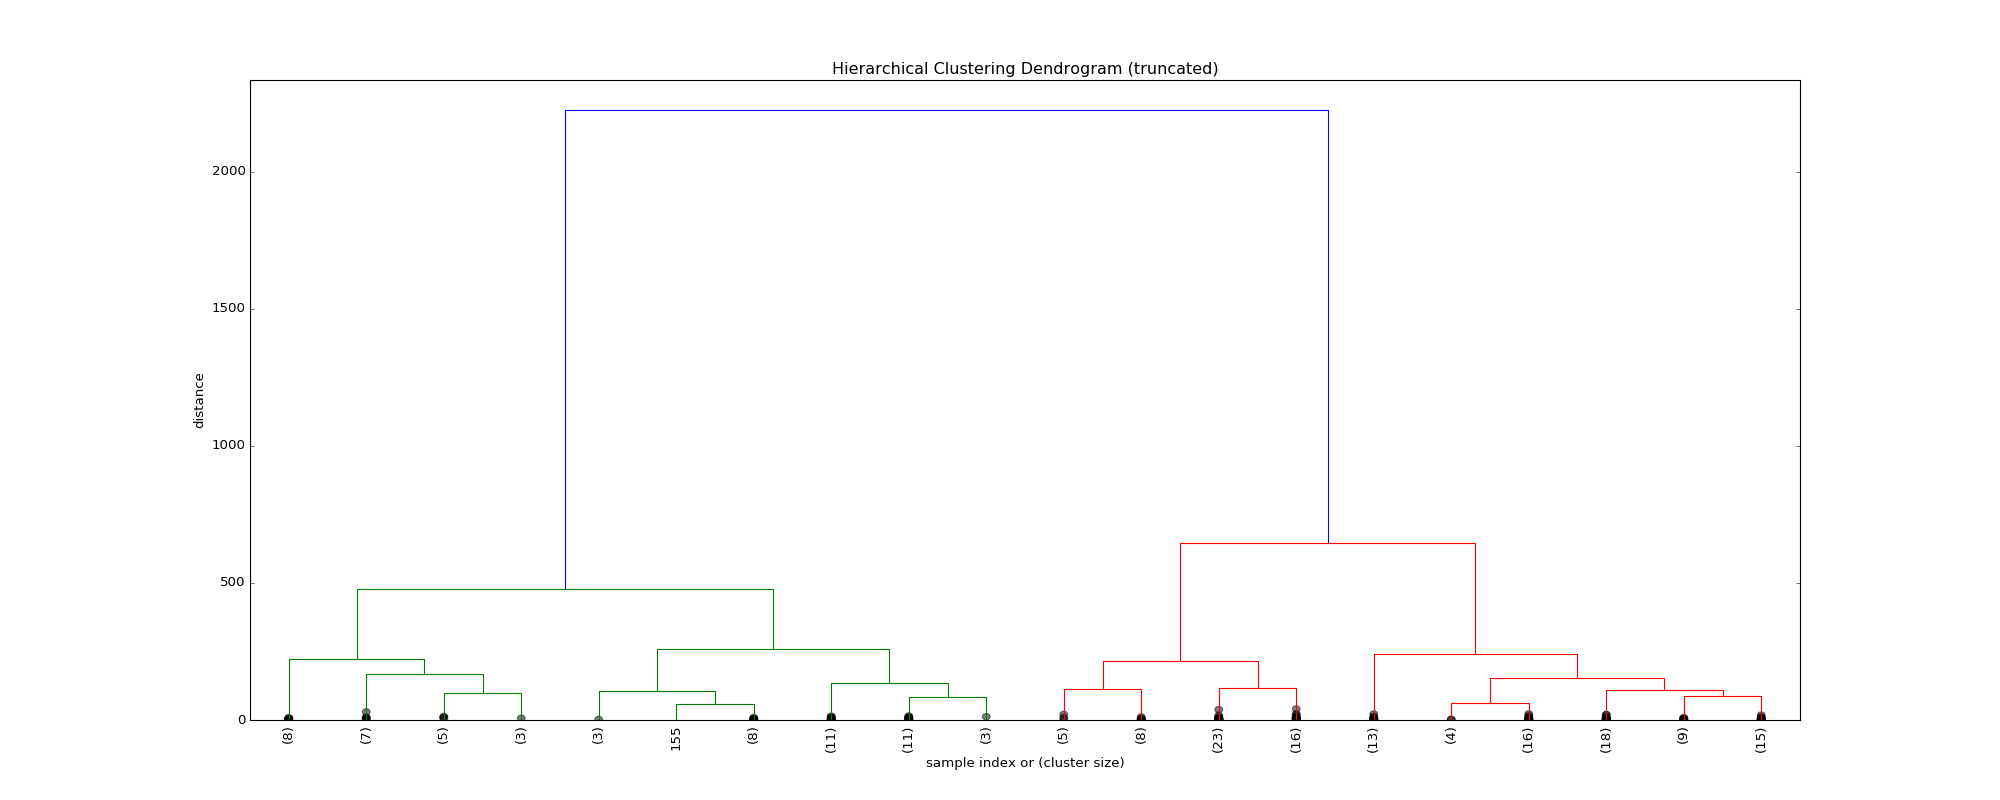

In [6]:
#Hierarchical clustering dendrogram (truncated)
fig3 = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
scipy.cluster.hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [7]:
max_d = 25
clusters = scipy.cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
print(max(clusters))
print(clusters)

35
[28 31 11 30 18  9 20  4  1 20 18  6 34 14 15  9 23 29 12 21 18  8  2 35 24
 33 26 26 28  1 32 28 29 15 28 17 33 32 24  1  5 32 31  2 27 14 35 32 30  9
  8 23 29 27  5 26 27 32 31 35 30 26 14 31  9 18 23  1  2  9 11 35 34 29 32
 19 20 24 32 27  7 21 14 29  9 30  1 35 34  5  9 20  2 34 20 12 21 13  5 12
 24 22 32 11 27 30 21 17 34 33 30 20 20  6 20 20 23 34 34  2 18 21 12 27 17
 17  1 32  1 18 33 18 27 24  5 26 20 12 33 21  3 34 30 29 14 32  1 12 14 21
 20 13 35 34 21 10  9 13 33 30 33 21 16 21 25 31 29 33 33 13 12 32 31 17 29
  8 23 24 12 23 31 27 25 13 20 25 23]


<IPython.core.display.Javascript object>


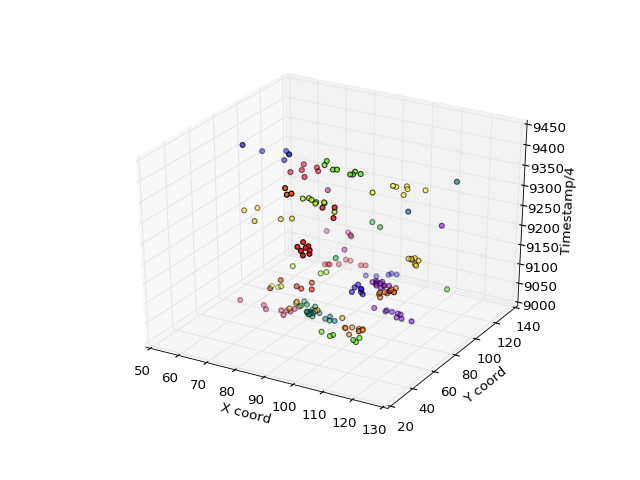

In [8]:
fig4 = plt.figure()
bx = fig4.add_subplot(111, projection='3d')
# plot points with cluster dependent colors
bx.scatter(B[:,0], B[:,1], B[:,2], c=clusters, cmap='prism')
bx.set_xlabel('X coord')
bx.set_ylabel('Y coord')
bx.set_zlabel('Timestamp/4')
plt.show()

In [9]:
#Which WRuns were clustered together
C={}
for count, key in enumerate(A):
    if (str(clusters[count]) not in C):
        C[str(clusters[count])] = [key]
    else:
        C[str(clusters[count])].append(key)
#Number of clusters
print(len(C))

35


In [19]:
################# Displays WR's as videos ##############
#To skip to the next dance press "Y"
#To close the window press "Esc"
#Path to the Waggle runs
path = '../Data/GTRuns/'

#control variables initialized
cluster = 0
next = 0
first_frame = True

while (cluster < len(C) and next != -1):
    cluster_key = str(cluster + 1)
    counter = 0
    while (counter < len(C[cluster_key]) and next != -1):    
        key = C[cluster_key][counter]
        pathWR = (path + key + '/')
        #vp object is initialized
        vp = VidPlayer()
        #waggle run images
        vp.set_vid_path(pathWR + 'image_%03d.png')
        capture = vp.get_vid_capture()
        #The video is played in a loop
        while(vp.get_vid_running()):
            ret, image = capture.read()
            if (ret == True):
                #image is resized
                image = cv2.resize(image, None, fx = 8, fy = 8, interpolation = cv2.INTER_CUBIC)
                #Info is displayed in the video window
                #Path is displayed
                cv2.putText(image,key,(10,20), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)
                #Counter is displayed
                cv2.putText(image,'WR %2d' %int(counter + 1),(350,16), cv2.FONT_HERSHEY_SIMPLEX, .25,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(image,'from %2d' %int(len(C[cluster_key])),(345,26), cv2.FONT_HERSHEY_SIMPLEX, .25,(255,255,255),1,cv2.LINE_AA)
                #Cluster number is displayed
                cv2.putText(image,'Cluster ' + cluster_key,(300,16), cv2.FONT_HERSHEY_SIMPLEX, .25,(255,255,255),1,cv2.LINE_AA)            
                #Angles are displayed            
                cv2.putText(image,'X0         = %5.4f ' %A[key][2],(10,342), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(image,'Y0         = %5.4f ' %A[key][3],(10,360), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(image,'Timestamp  = %5d   ' %A[key][4],(10,378), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)
                cv2.putText(image,'Dec_angle  = %5.4f' %float(A[key][1]*radi),(10,396), cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,255),1,cv2.LINE_AA)            
                cv2.imshow("Waggle Run", image)
                #Call to video player controls
                vp.vid_player_controlls()
            else:
                capture = vp.vid_restart()            
        if (vp.get_vid_direction() == 'right'):
            counter += 1            
        elif(vp.get_vid_direction() == 'left')  and (counter > 0):
            counter -= 1            
        elif(vp.get_vid_direction() == 'up'):
            cluster += 1
            break
        elif(vp.get_vid_direction() == 'down') and (cluster > 0):
            cluster -= 1
            break
        first_frame = True
        #cluster += 1
        next = vp.get_vid_dance()
    
    #Window is detroyed
capture.release()
cv2.destroyAllWindows()

In [106]:
#Which WRuns were clustered together
D={}
for count, key in enumerate(A):
    if (str(clusters[count]) not in D):
        D[str(clusters[count])] = [A[key][1]]
    else:
        D[str(clusters[count])].append(A[key][1])
print(len(D))

35


In [114]:
def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

def random_subset(n,n_data):
    #data array indexes
    all_idxs = np.arange( n_data )
    #shuffles the indexes
    np.random.shuffle(all_idxs)
    #the first n are returned
    idxs1 = all_idxs[:n]    
    return idxs1

def get_error(test_points, maybeAngle):
    diffAngle = []
    for count, angle1 in enumerate(test_points):
        #Angles are converted to vectors
        vTest = [math.cos(angle1),math.sin(angle1)]
        vMaybe = [math.cos(maybeAngle),math.sin(maybeAngle)]    
        #Difference is calculated using dot product
        escProd = np.dot(vTest,vMaybe)
        #limits the escProd to the range [-1,1]
        escProd = clamp(escProd, -1, 1)
        #
        diffAngle.append(math.acos(escProd))
    return np.array(diffAngle)

#Fit model to data using the RANSAC algorithm
"""
Given:
    data - a set of observed data points    
    n - the minimum number of data values required to fit the model
    k - the maximum number of iterations allowed in the algorithm
    t - a threshold value for determining when a data point fits a model
    d - the number of close data values required to assert that a model fits well to data
Return:
    bestfit - model parameters which best fit the data (or nil if no good model is found)
"""
def ransac_WDD(data, n, k, t, d):
    it = 0
    bestfit = None
    besterr = np.inf
    best_inlier_idxs = None
    while it < k:
        all_idxs = np.arange(data.shape[0])
        #generates a random subset
        maybe_idxs = random_subset(n,data.shape[0])
        maybeinliers = data[maybe_idxs]
        
        maybeAngle = stats.circmean(maybeinliers, high=2*np.pi, low=0)
        
        test_err = get_error(data, maybeAngle)
        
        inl_idxs = all_idxs[test_err < t] # select indices of rows with accepted points
        inliers = data[inl_idxs]
        
        if len(inliers) > d:
            betterdata = inliers
            bettermodel = maybeAngle
            better_errs = test_err
            thiserr = np.mean( better_errs )
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
                best_inlier_idxs = inl_idxs
        it+=1    
    else:
        return bestfit, best_inlier_idxs    

In [115]:
n = 3
t = np.pi/6

ransacAng = {}

for key in D:
    if len(D[key]) > 3:        
        data = np.array(D[key])
        k = 3*len(D[key])
        d = 0.7*len(D[key])
        #print('cluster ' + str(key) + ' with ' + str(len(D[key])) + ' elements')
        #print(D[key])
        #print(ransac_WDD(data, n, k, t, d))
        ransacAng[key]  = ransac_WDD(data, n, k, t, d)
ransacAng

{'1': (1.2613325998712104, array([0, 1, 2, 3, 4, 5, 6])),
 '12': (0.17224216585136562, array([0, 1, 2, 3, 4, 5, 6, 7])),
 '13': (0.14564925146820268, array([0, 2, 3, 4])),
 '14': (0.122073335839553, array([0, 1, 2, 3, 4])),
 '17': (0.34931566626230359, array([0, 1, 2, 3, 4])),
 '18': (None, None),
 '2': (5.821260055623136, array([0, 1, 3, 4])),
 '20': (0.5124136877341966,
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11])),
 '21': (0.19729818854824924, array([0, 1, 2, 3, 4, 5, 6, 8, 9])),
 '23': (0.28221079080308203, array([0, 1, 2, 3, 4, 5, 6])),
 '24': (None, None),
 '26': (5.9731504205327939, array([1, 2, 3, 4])),
 '27': (4.1583627408415946, array([0, 1, 2, 3, 4, 5, 6, 7])),
 '28': (4.5705646798578528, array([0, 1, 2, 3])),
 '29': (0.25671972559400486, array([0, 1, 2, 3, 4, 5, 6, 7])),
 '30': (0.46812563411531927, array([0, 2, 3, 5, 6, 7])),
 '31': (4.053517249755453, array([0, 2, 3, 5, 6])),
 '32': (4.2357111013177668,
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])),
 '33

[3.70818015339, 4.10304969831, 6.24979390324, 0.609900709634, 6.10652247751, 5.65560375742]


<IPython.core.display.Javascript object>


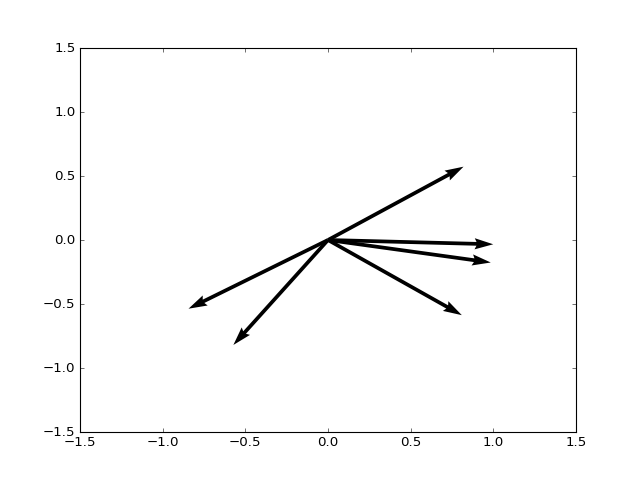

In [113]:
#Ploting orientation of WRuns orientations in a cluster
data = D['24']
print(data)

vec = np.array([[0 , 0, math.cos(angle), math.sin(angle)] for angle in data])
X, Y, U, V = zip(*vec)
fig5 = plt.figure()

cx = plt.gca()
cx.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
cx.set_xlim([-1.5, 1.5])
cx.set_ylim([-1.5, 1.5])
plt.draw()
plt.show()

In [ ]:
#Sandbox
for key in C:
    print(key)
    for i in C[key]:
        print(i)
        print(A[i])